In [1]:
# Load required modules

import numpy as np
import pandas
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

import scipy.signal

import random as rand

%matplotlib inline

In [2]:
# Class to easily load and plot APOGEE spectra

class APOGEESpec:
    def __init__(self, url):
        hdul = fits.open(url)

        self.flux_decomp = np.array(hdul[1].data)
        self.flux_err_decomp = np.array(hdul[2].data)

        self.flux = np.average(self.flux_decomp, axis=0, weights=self.flux_err_decomp**-2)
        self.flux_err = 1/np.sqrt(np.sum(self.flux_err_decomp**-2, axis=0))
        norm = np.nanmedian(self.flux)
        self.flux /= norm
        self.flux_err /= norm
        
        self.sky = hdul[5].data
        self.sky_err = hdul[6].data
        
        self.wave = 10**(hdul[1].header['CRVAL1'] + (hdul[1].header['CDELT1'] * np.arange(hdul[1].data.shape[1])))

    def plot(self, d=-1, ax=plt, errors=False, err_mul=1, **kwargs):
        if d==-1:
            f = self.flux
            err = self.flux_err
        else:
            f = self.flux_decomp[d]
            err = self.flux_err_decomp[d]
            
        if errors:
            ax.fill_between(self.wave, f - err*err_mul, f + err*err_mul, **kwargs)
        else:
            ax.plot(self.wave, f, **kwargs)

In [3]:
# Open all spectra into APOGEESPec objects

with open('../data/sample_star_urls_rev2', 'r') as f:
    urls = f.read().splitlines()

spectra = [ APOGEESpec('../data/spectra_rev2/%s' %url.split('/')[-1]) for url in urls ]

/tmp/ipykernel_925882/4275754558.py:10: RuntimeWarning: divide by zero encountered in power
  self.flux = np.average(self.flux_decomp, axis=0, weights=self.flux_err_decomp**-2)
/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
/tmp/ipykernel_925882/4275754558.py:11: RuntimeWarning: divide by zero encountered in power
  self.flux_err = 1/np.sqrt(np.sum(self.flux_err_decomp**-2, axis=0))
/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [4]:
# Compile all spectra into 2D arrays

wave = spectra[0].wave
allFlux = np.array([ spec.flux for spec in spectra ])
allErrs = np.array([ spec.flux_err for spec in spectra])

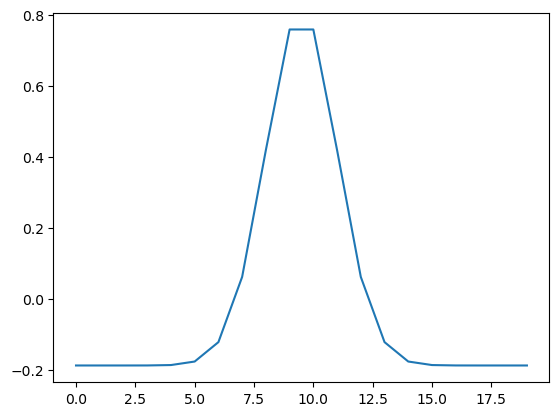

In [5]:
window = scipy.signal.windows.gaussian(20, 1.5)
window = window - np.mean(window)

plt.plot(window)

0.3565686295770444
21


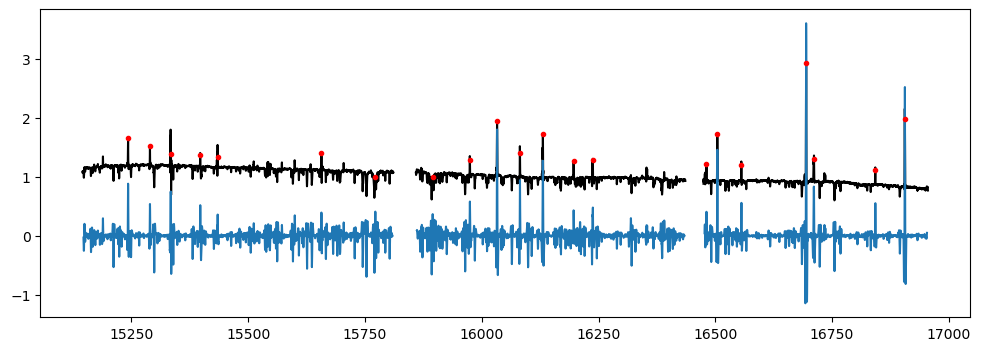

In [6]:
flux = allFlux[33]

conv = np.correlate(flux, window, mode='same')

limit = np.nanpercentile(conv, 99)
print(limit)
features = scipy.signal.find_peaks(conv, height=limit)[0]
print(len(features))
plt.figure(figsize=(12,4))
plt.plot(wave, flux, color='black')
plt.plot(wave, conv)
plt.plot(wave[features], flux[features], '.', color='red')

#plt.xlim(15700, 15800)

In [7]:
def find_features(flux, window):
    conv = np.correlate(flux, window, mode='same')
    
    return scipy.signal.find_peaks(conv, height=0.3)[0]

features = [ find_features(flux, window) for flux in allFlux ]

allFeatures = np.concatenate(features)

(16000.0, 16250.0)

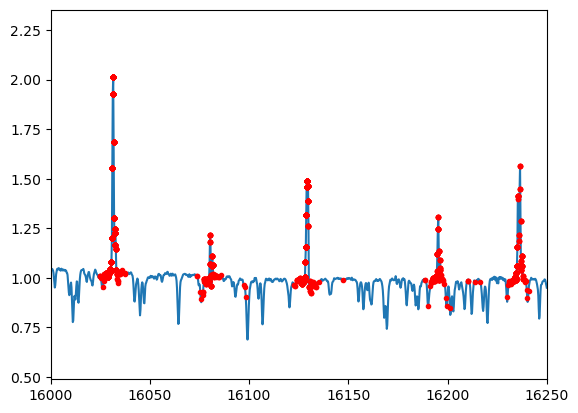

In [8]:
plt.plot(wave, allFlux[0])
plt.plot(wave[allFeatures], allFlux[0][allFeatures], '.', color='red')
plt.xlim(16000, 16250)

In [9]:
featureHistogram = np.histogram(allFeatures, range(len(wave)+1))[0]
featureSmooth = np.convolve(featureHistogram, scipy.signal.windows.gaussian(300, 20), mode='same')

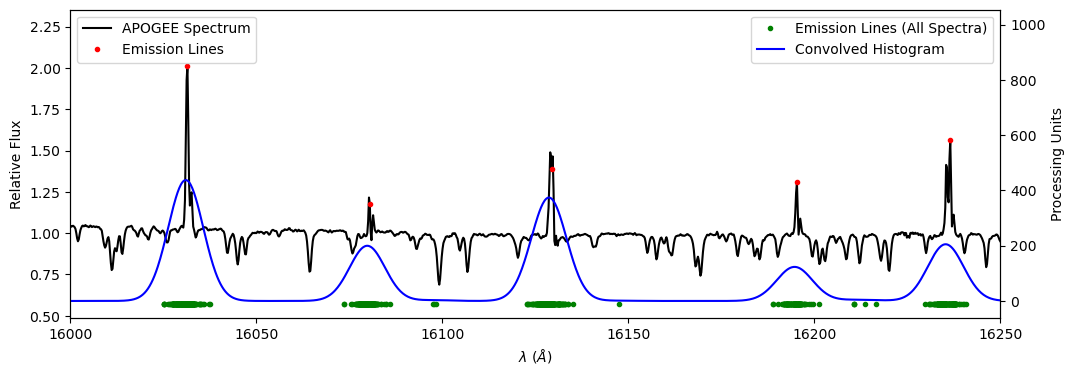

In [10]:
plt.figure(figsize=(12,4))

plt.plot(wave, allFlux[0], color='black', label='APOGEE Spectrum')
plt.plot(wave[features[0]], allFlux[0][features[0]], '.', color='red', label='Emission Lines')

plt.legend(loc=2)
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')
plt.twinx().plot(wave[allFeatures], [-10]*len(allFeatures), '.', color='green', label='Emission Lines (All Spectra)')

plt.plot(wave, featureSmooth, color='blue', label='Convolved Histogram')

plt.legend()
plt.ylabel(r'Processing Units')

_ = plt.xlim(16000, 16250)

In [ ]:
plt.figure(figsize=(12,4))

for i in range(len(allFlux)):
    if i == 0:
        plt.plot(wave, allFlux[i], alpha=0.1, color='black', label='APOGEE Spectra')
        plt.plot(wave[features[i]], allFlux[i][features[i]], '.', color='red', label='Emmision Lines (All Spectra)')
    else:
        plt.plot(wave, allFlux[i], alpha=0.1, color='black')
        plt.plot(wave[features[i]], allFlux[i][features[i]], '.', color='red')
plt.plot(wave[featureSmooth > 3], [0] * sum(featureSmooth > 3), '.', ms=1, label='Atmospheric Interference')
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.legend()
plt.ylabel('Relative Flux')
_ = plt.xlim(16070, 16090)
_ = plt.ylim(-0.5, 2.5)